In [178]:
%matplotlib notebook

%matplotlib inline

import sys

if "." not in sys.path:
    sys.path.insert(0, ".")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string
import sklearn

## add your packages ##

# Transformation
from bioinfokit.analys import norm

# 2D Visualization
from sklearn.decomposition import PCA
from openTSNE import TSNE
import umap

# metrics
from dcor import distance_correlation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
)
from sklearn.preprocessing import OneHotEncoder


# clustering
import igraph as ig
import leidenalg as la
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# other
import ipywidgets as widgets
from ipywidgets import fixed, interact, interact_manual, interactive
from tqdm import tqdm
from utils import *

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import black
import jupyter_black

jupyter_black.load(line_length=79)
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
intermediate_path = Path("../results/intermediate")
data_path = Path("./data")
plt.style.use("../matplotlib_style.txt")

import os

os.makedirs(variables_path, exist_ok=True)
os.makedirs(figures_path, exist_ok=True)
os.makedirs(intermediate_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

np.random.seed(142)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (TSNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

# Data Loading 

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [179]:
# META DATA

meta = pd.read_csv(data_path / "m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [180]:
# READ COUNTS

data_exons = pd.read_csv(
    data_path / "m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [181]:
# GENE LENGTH

data = pd.read_csv(data_path / "gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

print("Number of genes:", len(genes))
genes

Number of genes: 42466


array(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', ..., 'n-R5s98',
       'n-TSaga9', 'n-TStga1'], dtype=object)

### Cluster colors

In [182]:
cluster_colors = np.load(data_path / "cluster_colors.npy")
cluster_colors.shape

(1329,)

In [183]:
rna_type = np.load(data_path / "rna_type.npy", allow_pickle=True)
rna_type.shape

(1329,)

In [184]:
pickle_in = open(data_path / "dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)
len(dict_rna_type_colors)

88

### Electrophysiological features

In [185]:
# EPHYS DATA

ephysData = pd.read_csv(data_path / "m1_patchseq_ephys_features.csv")
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [186]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]
# get actual names of features
ephysNames_filtered = ephysNames[~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)

X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

(1329, 29)
(1320, 17)


In [187]:
# eliminate cells that do not have electrophysiological data
cells_filtered = cells[keepcells]
exonCounts = exonCounts[keepcells, :]
cluster_colors = cluster_colors[keepcells]
rna_type = rna_type[keepcells]

# Data Inspection

**Description of the relevant data:**
- exonCounts:           Array of dimensions $n_{cells} \times n_{genes}$. Holds the read counts of the genes for every cell.
- exonLengths:          Array of dimensions $n_{genes} \times 1$. Holds the lengths of the respective genes. Needed for some normalization techniques.
- genes:                Array of dimensions $n_{genes} \times 1$. Holds the names of the genes.
- cluster_colors:       Array of dimensions $n_{cells} \times 1$. Holds membership information to a cluster of each cell.
- rna_type:             Array of dimensions $n_{cells} \times 1$. Holds information about the RNA type of each cell.
- ephysData_filtered:   Array of dimensions $n_{cells} \times 17$. Holds values of overall 17 explored electrophysical features of each cell.
- ephysNames_filtered:  Array of dimensions $17 \times 1$. Names of the examined electrophysical features.
- cells_filtered:       Array of dimensions $n_{cells} \times 1$. Holds names of examined cells.
 

In [188]:
# print shapes of relevant data
print("shape of exonCounts: ", exonCounts.shape)
print("shape of exonLengths: ", exonLengths.shape)
print("shape of genes: ", genes.shape)
print("shape of cluster_colors: ", cluster_colors.shape)
print("shape of rna_type: ", rna_type.shape)
print("shape of ephysNames_filtered: ", ephysNames_filtered.shape)
print("shape of ephysData_filtered: ", ephysData_filtered.shape)
print("shape of cells_filtered: ", cells_filtered.shape)

shape of exonCounts:  (1320, 42466)
shape of exonLengths:  (42466,)
shape of genes:  (42466,)
shape of cluster_colors:  (1320,)
shape of rna_type:  (1320,)
shape of ephysNames_filtered:  (17,)
shape of ephysData_filtered:  (1320, 17)
shape of cells_filtered:  (1320,)



Before we begin we remove all genes that exhibit no expression.

In [189]:
# kick out genes with no expression
keepgenes = np.sum(exonCounts, axis=0) > 0
exonCounts = exonCounts[:, keepgenes]
genes = genes[keepgenes]
exonLengths = exonLengths[keepgenes]

## Feature Selection

In accordance with the methodology proposed by Kobak & Berens (2019), we choose features (genes) based on their mean-dropout relationship, as described by Andrews and Hemberg (2018).

In [190]:
# exclude genes with less than 32 counts in all but 10 cells
cmin = 32
n_cells = np.sum(exonCounts >= cmin, axis=0)
exclude = n_cells < 10

exonCounts_filtered_0 = exonCounts[:, ~exclude]
genes_filtered_0 = genes[~exclude]
exonLengths_filtered_0 = exonLengths[~exclude]


# Calculate Mean Log Non-Zero Expression and Dropout Rate for Each Gene
# dropout rate
d_g = np.mean(exonCounts_filtered_0 <= cmin, axis=0)

# mean log non-zero expression
# write ones for every value that is less than or equal to cmin (log(1) = 0)
variable_exonCount_log = exonCounts_filtered_0.copy()
variable_exonCount_log[exonCounts_filtered_0 <= cmin] = 1
variable_exonCount_log = np.log2(variable_exonCount_log)
m_g = np.array(
    [
        np.mean(
            variable_exonCount_log[:, i][variable_exonCount_log[:, i] != 0]
        )
        for i in range(variable_exonCount_log.shape[1])
    ]
)

In [191]:
# boundary function to get the threshold (adopted from Kobak & Berens 2019)
def boundary(mu, b):
    return np.exp(-1.5 * (mu - b)) + 0.02


# perform binary search to get 500 genes that fullfil the criteria
def binary_search(mu, num_genes):
    """
    Binary search for the optimal value of theta
    """
    alpha_min = 0
    alpha_max = 500
    alpha = (alpha_min + alpha_max) / 2
    i = 0
    while np.sum(d_g > boundary(mu, alpha)) != num_genes and i < 1000:
        if np.sum(d_g > boundary(mu, alpha)) < num_genes:
            alpha_max = alpha
        else:
            alpha_min = alpha
        alpha = (alpha_min + alpha_max) / 2
        # print(alpha)
        i += 1
    return alpha, d_g > boundary(mu, alpha)


offset, idx = binary_search(m_g, 500)

In [192]:
def plot_filtering(offset=offset):
    x = np.linspace(5, 14, 100)

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_xlabel("mean log non-zero expression")
    ax.set_ylabel("fraction of near-zero counts")
    ax.set_ylim(0, 1)
    ax.plot(
        x, boundary(x, offset), color="black", linestyle="--", label="boundary"
    )
    boundary_colors = np.array(["blue", "green"])[
        (d_g > boundary(m_g, offset)).astype(int)
    ]
    ax.scatter(m_g, d_g, s=1, c=boundary_colors, label="genes", alpha=0.5)

    filtered_gene_count = np.sum(boundary_colors == "green")
    ax.legend()
    plt.show()
    print(f"Resulting gene count {filtered_gene_count}")

In [193]:
offset_slider = widgets.FloatSlider(
    value=offset,
    min=offset * 0.65,
    max=offset * 1.3,
    step=0.01,
    description="offset",
)

print(
    f"This is an interactive plot. It is only visible in the Jupyter Notebook."
)

out = widgets.interactive_output(plot_filtering, {"offset": offset_slider})

widgets.HBox([widgets.VBox([offset_slider, out])])

This is an interactive plot. It is only visible in the Jupyter Notebook.


As proposed by Scala et al. (2021), we choose the 500 most variable genes for our analysis. The offset such that exactly 500 genes remain is found via Binary search.

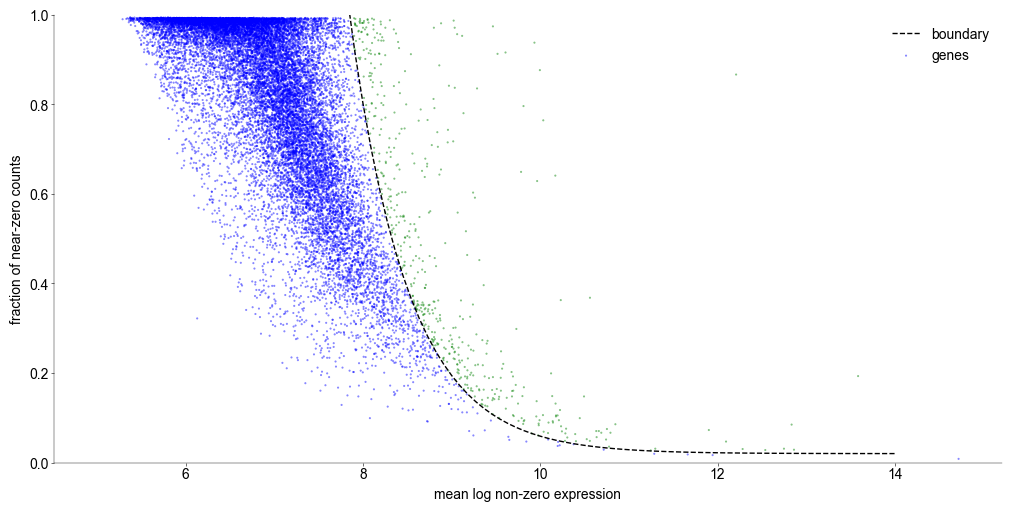

Resulting gene count 500


In [194]:
# static plot for pdf:
offset, idx = binary_search(m_g, 500)
plot_filtering(offset=offset)

In [195]:
exonCounts_filtered = exonCounts_filtered_0[:, idx]
genes_filtered = genes_filtered_0[idx]
exonLengths_filtered = exonLengths_filtered_0[idx]
exonCounts_filtered.shape

(1320, 500)

##  Compute Statistics

In this brief subsection, we compute various statistics from the remaining data, namely, average expression (avg_expr), fraction of zero gene expression (frac_zeros), variance of gene expression (var_expr), and the fano factor (fano_factor). We then compare these statistics with a Poisson distribution (like in the exercise), despite being aware that the data was not obtained through Unique Molecular Identifiers (UMI), so a match is not expected.


In [196]:
# Compute the average expression for each gene
avg_expr = np.mean(exonCounts_filtered, axis=0)
frac_zeros = np.mean(exonCounts_filtered == 0, axis=0)

# compute variance
var_expr = np.var(exonCounts_filtered, axis=0)

# Compute fano factor
fano_factor = var_expr / avg_expr

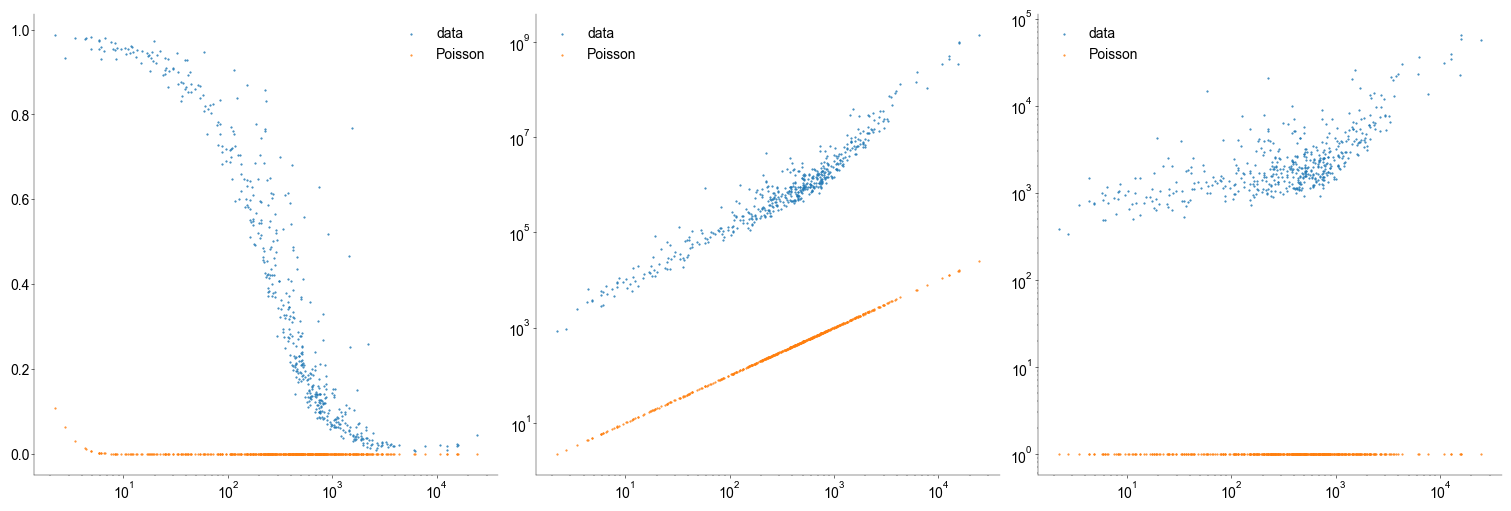

In [197]:
# visualize that the distribution does indeed not follow a poisson distribution

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(avg_expr, frac_zeros, s=1, label="data")
axs[0].scatter(avg_expr, np.exp(-avg_expr), s=1, label="Poisson")

axs[1].scatter(avg_expr, var_expr, s=1, label="data")
axs[1].scatter(avg_expr, avg_expr, s=1, label="Poisson")

axs[2].scatter(avg_expr, fano_factor, s=1, label="data")
axs[2].scatter(avg_expr, np.ones_like(avg_expr), s=1, label="Poisson")

for i, ax in enumerate(axs):
    ax.set_xscale("log")
    if i != 0:
        ax.set_yscale("log")
    ax.legend()

plt.show()

**Analysis:** We can see what was already given in the task description, i.e. that the data does not follow a Poisson distribution because it is not acquired via UMI.

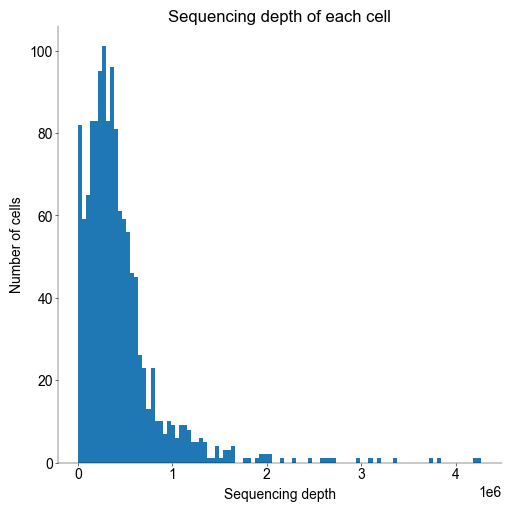

In [198]:
# plot sequencing depth of each cell

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(np.sum(exonCounts_filtered, axis=1), bins=100)
ax.set_title("Sequencing depth of each cell")
ax.set_xlabel("Sequencing depth")
ax.set_ylabel("Number of cells")

plt.show()

We can see that most cells have a sequencing depth of less than $10^6$, with only a few outliers above $2\cdot 10^6$

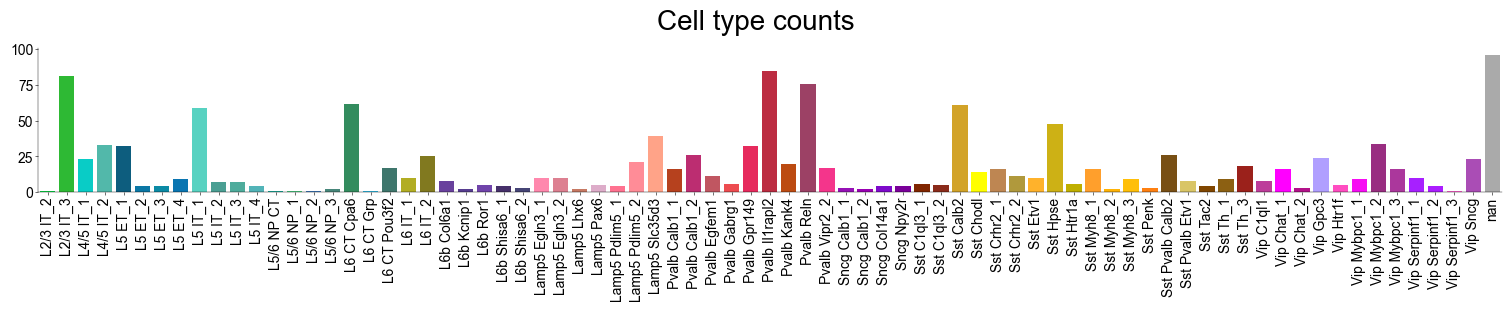

In [199]:
rna_type_names, cell_type_counts = np.unique(
    rna_type.astype(str), return_counts=True
)

fig, ax = plt.subplots(figsize=(15, 3))
ax.bar(
    np.arange(len(cell_type_counts)),
    cell_type_counts,
    color=[
        dict_rna_type_colors[rna_type_name]
        if rna_type_name != "nan"
        else "#aaaaaa"
        for rna_type_name in rna_type_names
    ],
)
ax.set_xticks(np.arange(len(cell_type_counts)))
ax.set_xlim([-0.5, len(cell_type_counts) - 0.5])
ax.set_xticklabels(rna_type_names, rotation=90)
fig.suptitle("Cell type counts", fontsize=20)
plt.show()

This plot illustrates the cellular distribution of RNA types. The colors used correspond to those employed in the 2D visualization section.

# Data Normalization and Transformation


In the exercise sheet related to transcriptomic data analysis, we standardized the counts by expressing them as counts per median sequencing depth. Since the data does not consist of unique molecular identifier (UMI) counts, we applied two distinct normalization methods: counts per million (CPM) and reads per kilobase per million (RPKM). Additionally, we applied both log-transformation and square root-transformation to the normalized data in each case.


## Counts per million (CPM)

In order to obtain CPM, we have to perform the following calculation for each cell:

$$ CPM = \frac{\text{Read counts mapped to gene}}{\text{Total number of mapped reads}} \times 10^6 $$

For this, the bioinfokit.analys library is used.


In [200]:
# convert exonCounts to dataframe
df = pd.DataFrame(
    exonCounts_filtered.T, columns=cells_filtered, index=genes_filtered
)

In [201]:
# Normalization: CPM
nm = norm()
nm.cpm(df)
cpm_df = nm.cpm_norm


# Transformation: Log2 and sqrt transform
cpm_counts = cpm_df.values.T
cpm_counts_log = np.log2(cpm_counts + 1)  # + 1 to avoid log(0)
cpm_counts_sqrt = np.sqrt(cpm_counts)

## Reads per kilobase per million (RPKM)

RPKM addresses the issue of variations in gene lengths and sequencing depths:

$$ RPKM = \frac{{\text{Number of uniquely mapped reads to the gene}}}{{\text{gene length in KB} \times \text{Total mapped reads in the sample}}} \times 10^6$$

Again, we use the bioinfokit package to obtain the normalized counts.

In [202]:
# add column with lengths to df
df["length"] = exonLengths_filtered

# Normalization
nm = norm()
nm.rpkm(df=df, gl="length")
rpkm_df = nm.rpkm_norm

# Log and sqrt transform
rpkm_counts = rpkm_df.values.T
rpkm_counts_log = np.log(rpkm_counts + 1)
rpkm_counts_sqrt = np.sqrt(rpkm_counts)

# 3. Two-dimensional Visualization

In this section, our objective is to create two-dimensional visualizations of our high-dimensional data. To achieve this, we utilize two algorithms: TSNE and UMAP. You can find more detailed explanations of these algorithms in their respective sections.

To make the dimensionality reduction computationally feasible, we follow the approach proposed by Kobak and Berens (2019) and apply it to the first fifty principal components.

In evaluating the quality of the resulting visualizations, we begin by conducting a qualitative assessment. Subsequently, we utilize quantitative metrics such as KNN accuracy and distance correlation. We conduct a grid search over the hyperparameters, optimizing the performance of the two algorithms, measured by the mean of the distance correlation score and the normalized KNN accuracy. 

## Qualitative Analysis

In [203]:
# create a dictionary with the different count types to make it easy to iterate over them

count_dict = {
    "unnormalized": {
        "raw": exonCounts_filtered,
        "log": np.log2(exonCounts_filtered + 1),
        "sqrt": np.sqrt(exonCounts_filtered),
    },
    "cpm": {
        "raw": cpm_counts,
        "log": cpm_counts_log,
        "sqrt": cpm_counts_sqrt,
    },
    "rpkm": {
        "raw": rpkm_counts,
        "log": rpkm_counts_log,
        "sqrt": rpkm_counts_sqrt,
    },
}

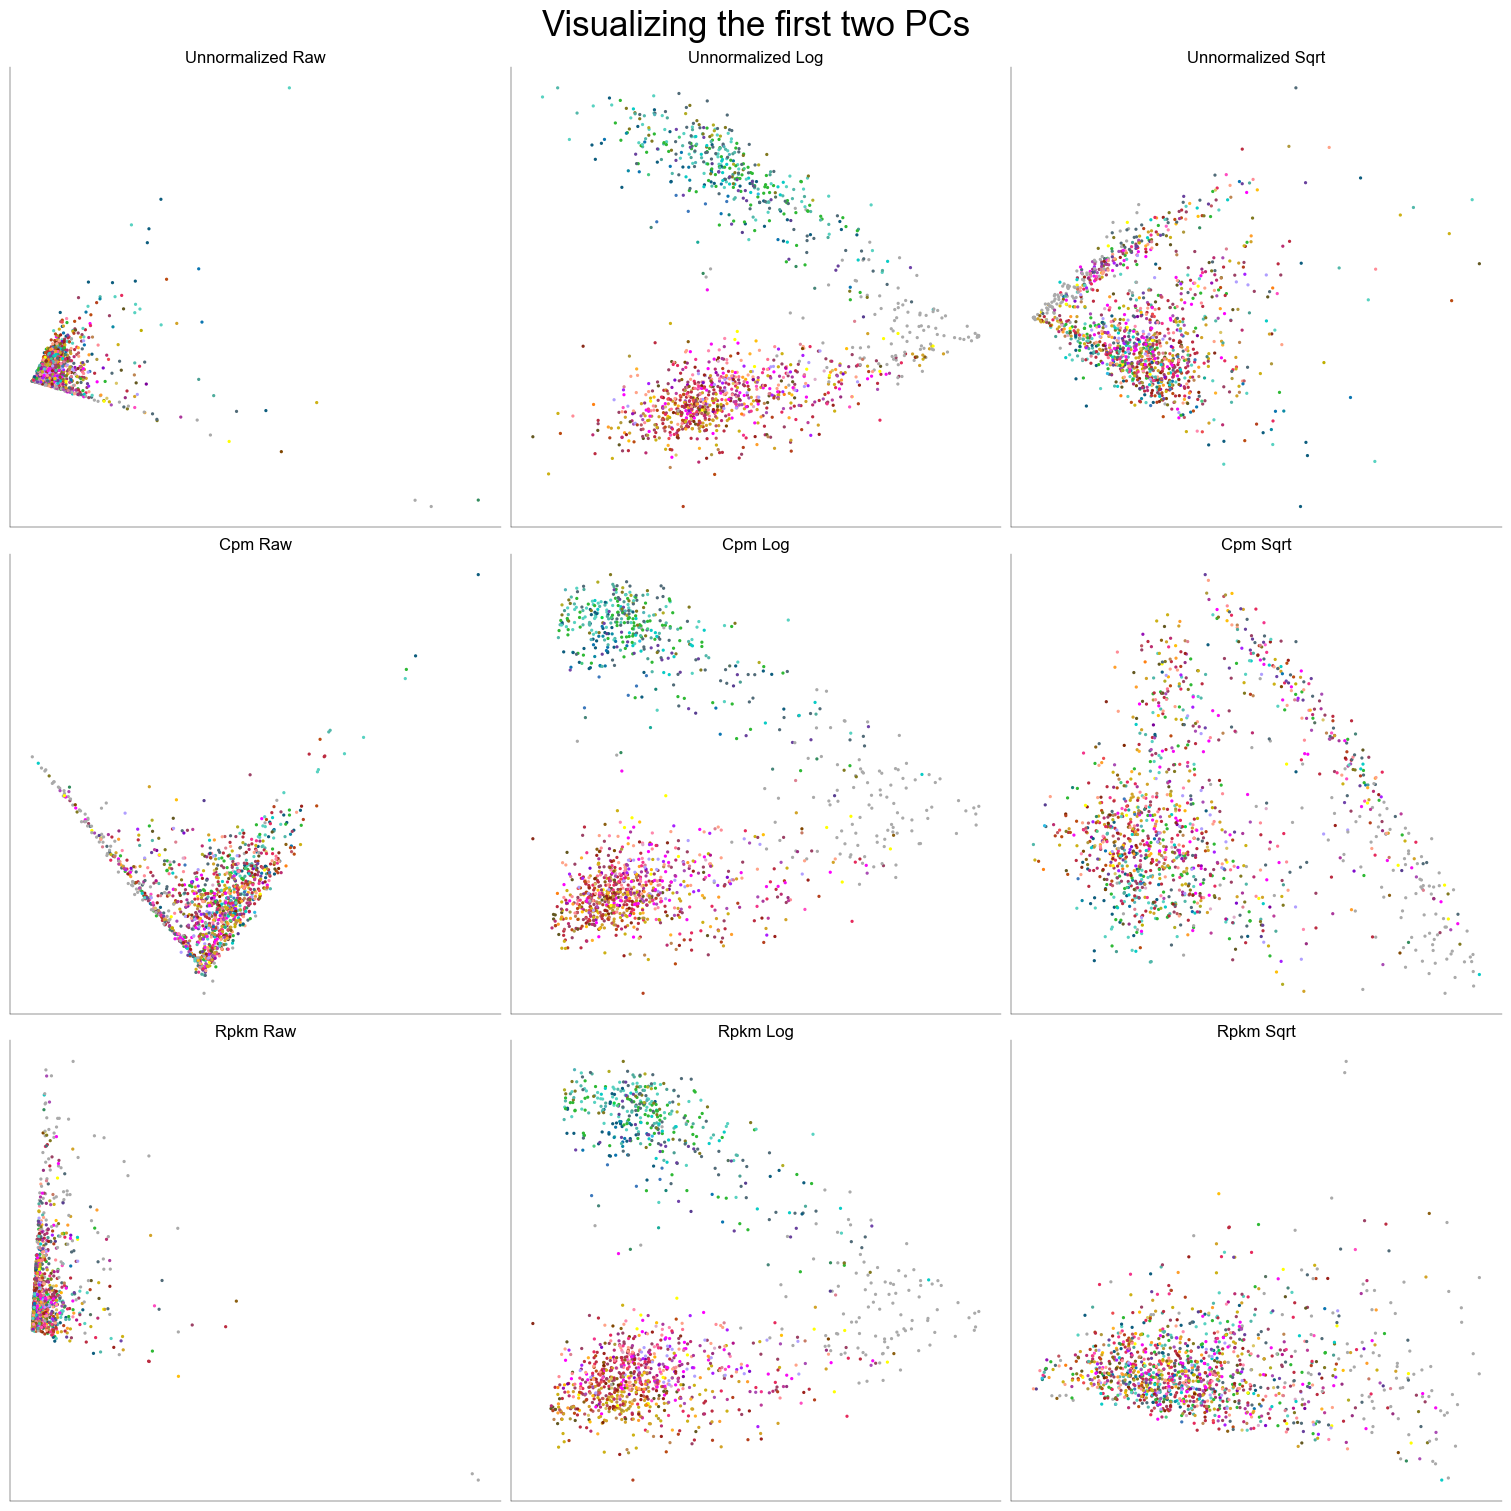

In [204]:
# perform PCA fit
pca = PCA(n_components=50)
pca_results = dict()
pca_components = dict()
for norm_key, sub_dict in count_dict.items():
    pca_results[norm_key] = dict()
    pca_components[norm_key] = dict()
    for trans_key, counts in sub_dict.items():
        pca_results[norm_key][trans_key] = pca.fit_transform(counts)
        pca_components[norm_key][trans_key] = pca.components_

# plot PCA results
plot_2d_vis(pca_results, "Visualizing the first two PCs", cluster_colors)

**Qualitative Analysis:** 

In this visualization (especially in the plots with log transform) we can already see a clear distinction between two different groups of similar cell-types, such as Layer 2-5 ET/IT cells (green-ish) and Lamp5, Pvalb cells (red-ish). See the bar plot titled "cell type counts" in the "Compute Statistics" section. Additionally, we can see that all cells labelled 'nan' (gray) are assembled in the middle Within these two groups however, we do not get a finer grain clustering. Thus a further examination with TSNE and UMAP is necessary. 

### TSNE

**Description of the algorithm:**

TSNE (t-distributed Stochastic Neighbor Embedding) introduced by Van der Maaten and Hinton (2008) is a dimensionality reduction algorithm used to map high-dimensional data into a lower-dimensional space, typically for visualization purposes. It aims to preserve the relationships between data points, especially the local structure of the data, by mapping similar points close together and dissimilar points far apart. It does this my minimizing the following objective. (formulas taken from Kobak and Berens, 2019)

$$\mathcal{L} = \sum_{i, j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$$  
Where:
\begin{align*}
p_{ij} &= \frac{p_{i|j}+p_{j|i}}{2n}\\
p_{i|j} &= \frac{\exp\left(-\frac{\lVert x_i - x_j \rVert^2}{2\sigma_i^2}\right)}{\sum_{k \neq i}\exp\left(-\frac{\lVert x_i - x_k \rVert^2}{2\sigma_i^2}\right)} \\
q_{ij} &= \frac{\left(1 + \lVert y_i - y_j \rVert^2\right)^{-1}}{\sum_{k \neq l} \left(1 + \lVert y_k - y_l \rVert^2\right)^{-1}}
\end{align*}

In our scenario, we apply TSNE to our PCA results, meaning we use a 50-dimensional $x$ for the TSNE transformation.

In [205]:
# perform TSNE of PCA results with default parameters
tsne = TSNE()
tsne_results = dict()
for norm_key, sub_dict in pca_results.items():
    tsne_results[norm_key] = dict()
    for trans_key, result in sub_dict.items():
        tsne_results[norm_key][trans_key] = tsne.fit(result)

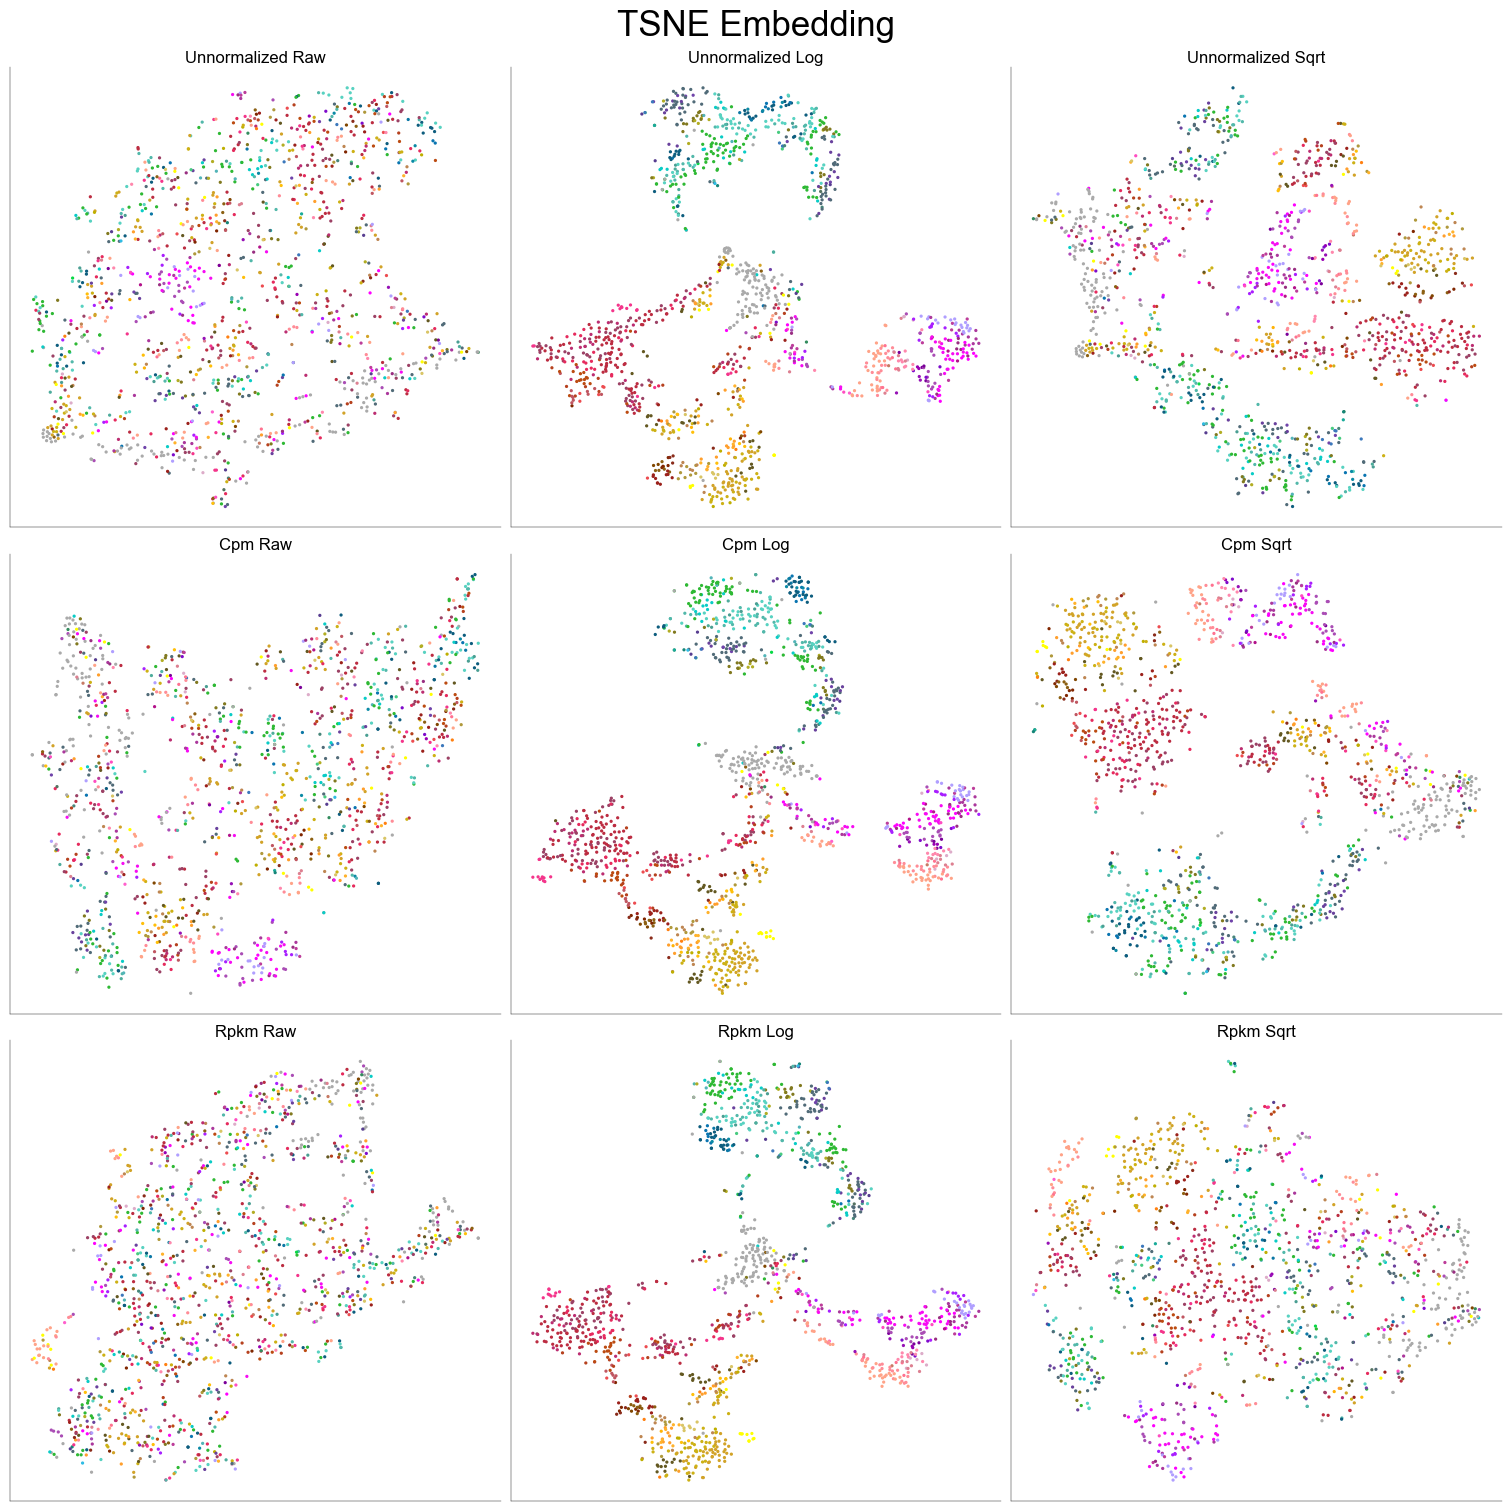

In [206]:
plot_2d_vis(tsne_results, "TSNE Embedding", cluster_colors)

**Qualitative Analysis:** The original data (left column) does not exhibit satisfactory clustering results. The square-root transformation (right column) also shows limitations, especially when dealing with unnormalized and RPKM-normalized data. On the other hand, log-transformations (middle column) appear to yield the best results. Here we can again see the structure of red-ish and green-ish points being close to each other and nans being in the middle of the plot. But in contrast to PCA there is also much finer grained clustering within these groups.

### UMAP

**Descripton of the algorithm:** 

UMAP (Uniform Manifold Approximation and Projection) was introduced by McInnes et al. (2018). It aims to preserve the local and global structure of the data by finding a low-dimensional representation where similar data points are closer together while dissimilar points are further apart. UMAP achieves this by optimizing two main objectives:

1. Local Connectivity Preservation: Ensures that points are close in the low-dimensional space, when they are close in the high-dimensional space
2. Minimizing Cross-Entropy: Minimizing the cross-entropy between the pairwise probability distributions in the high-dimensional and the low-dimensional space aids to preserve the global structure.

In [207]:
umap_func = umap.UMAP()
umap_results = dict()
for norm_key, sub_dict in pca_results.items():
    umap_results[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        umap_results[norm_key][trans_key] = umap_func.fit_transform(pca_result)

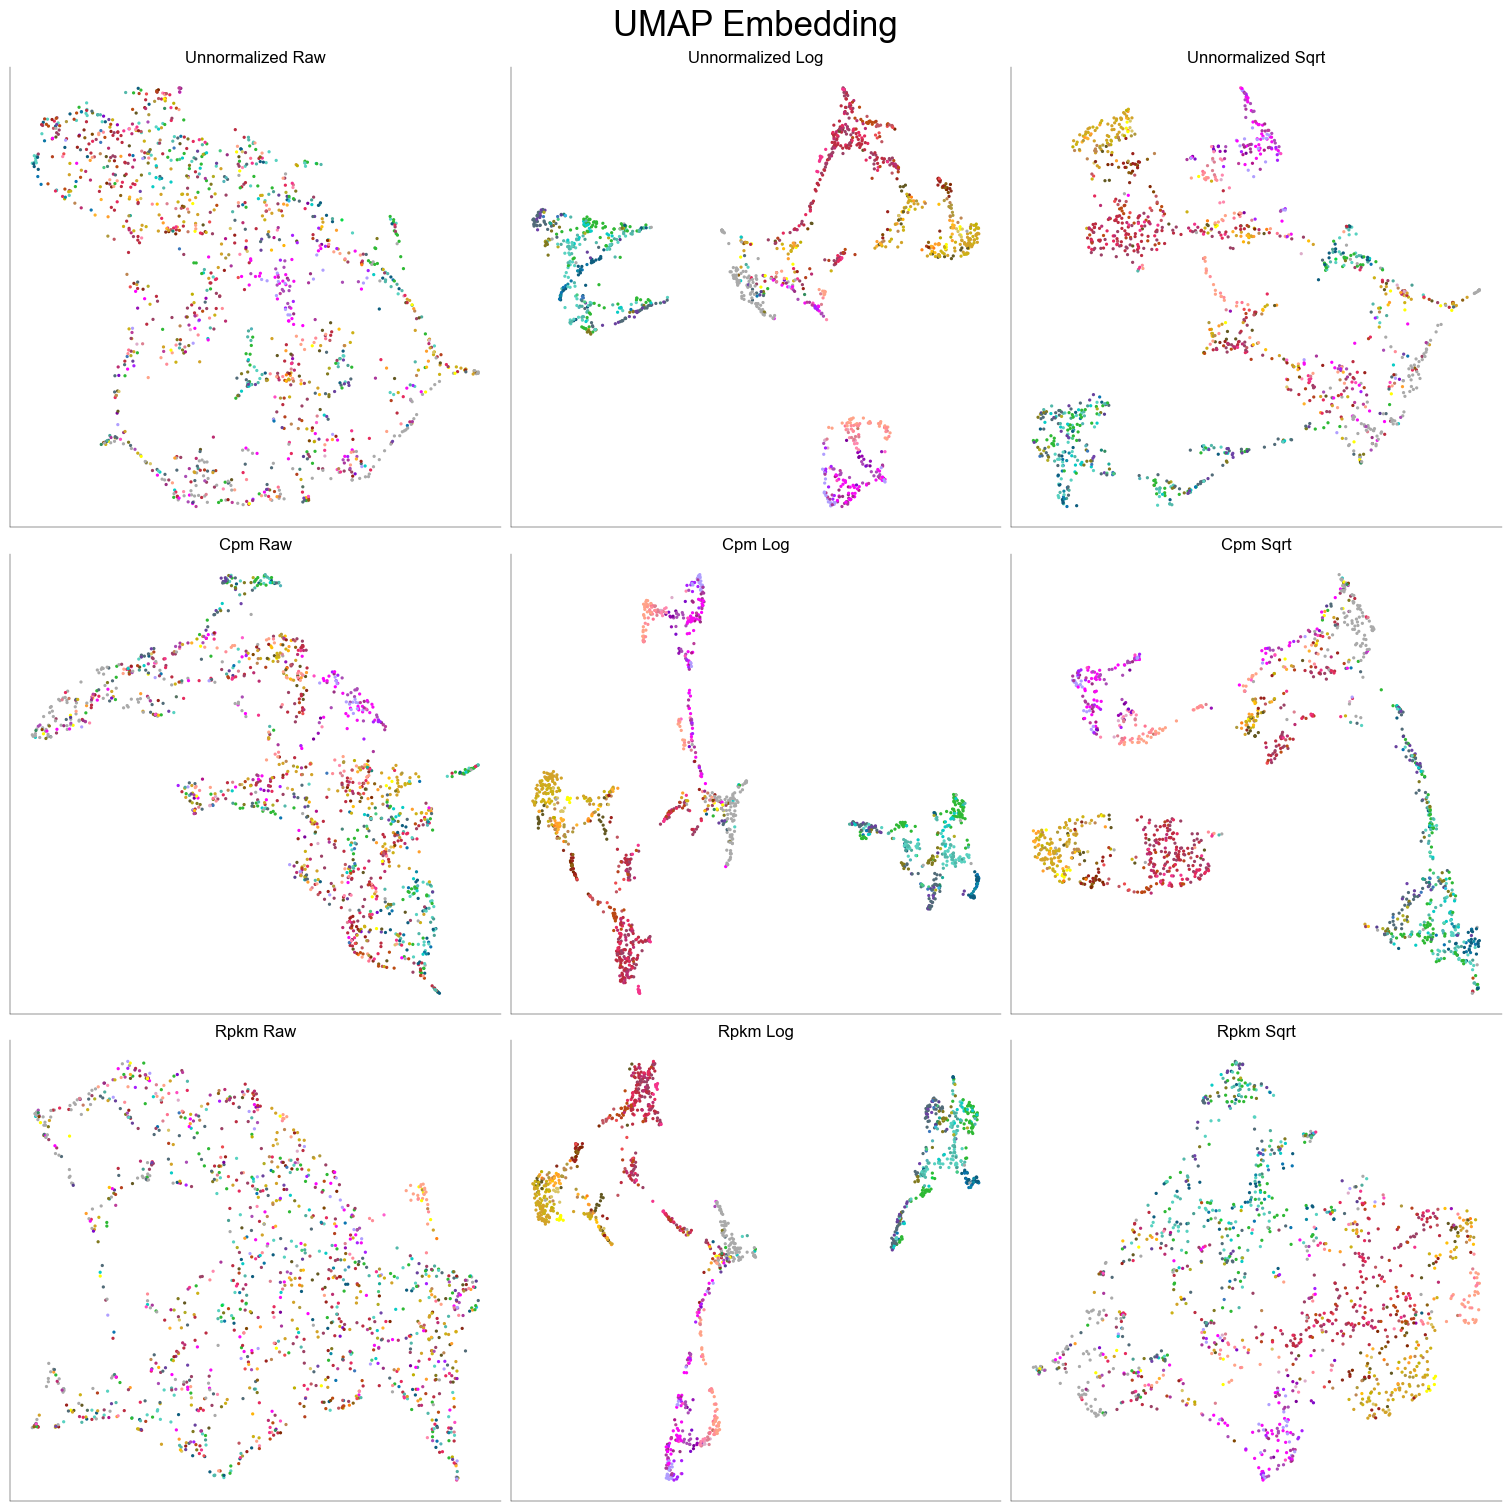

In [208]:
plot_2d_vis(umap_results, "UMAP Embedding", cluster_colors)

**Qualitative Analysis:** Similar to the previous observation, the original data (left column) does not produce satisfactory results in terms of clustering. The square-root transformation (right column) reveals the cluster structure better than TSNE. Nevertheless, our conclusion is that log-transformations (middle column) offer the most meaningful two-dimensional visual representation of the underlying ground truth cluster structure. 

As a result, we choose to focus our further, quantitative analysis solely on the middle column, disregarding the unnormalized log-transformed data (since normalization is standard in the literature). 

In [209]:
# remove keys from result dictionary

result_dicts = [count_dict, pca_results, tsne_results, umap_results]

remove_norms = ["unnormalized"]  # ["raw", "cpm", "rpkm"]
remove_transforms = ["raw", "sqrt"]  # ["counts", "log", "sqrt"]

for result_dict in result_dicts:
    for norm in remove_norms:
        try:
            del result_dict[norm]
        except KeyError:
            pass

for result_dict in result_dicts:
    for norm_key, sub_dict in result_dict.items():
        for trans in remove_transforms:
            try:
                del sub_dict[trans]
            except KeyError:
                pass

## Quantitative Analysis

In order to subject our two-dimensional representations to quantitative analysis, we needed to make the results measurable. To achieve this, we employed KNN accuracy and distance correlation and a combination of the two as our evaluation metrics.

Furthermore, this combined score was utilized to conduct a grid search over the parameter space of TSNE and UMAP, enabling us to identify the optimal hyperparameters for the algorithms.


### Implementation of different Metrics

- Distance correlation: measures the similarity of pairwise distances in the original data space and the corresponding transformed space.
- KNN Accuracy: Fits a KNN classifier on the two-dimensional data and calculates the accuracy compared to the ground truth. To make things fair, we optimized each classifier in terms of number of neighbors seperately.
- Normalized KNN Accuracy: Normalizes the KNN Accuracy of the 2D representation by the KNN Accuracy of the high-dimensional (50) data.
- Combined Score: Mean of the distance correlation and the normalized KNN accuracy.

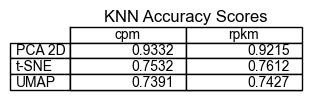

In [210]:
# Calculate distance correlation
pca_dc = dict()
tsne_scores = dict()
umap_dc = dict()

for norm_key, sub_dict in pca_results.items():
    pca_dc[norm_key] = dict()
    tsne_scores[norm_key] = dict()
    umap_dc[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        pca_dc[norm_key][trans_key] = distance_correlation(
            pca_result, pca_result[:, :2]
        )
        tsne_scores[norm_key][trans_key] = distance_correlation(
            pca_result, tsne_results[norm_key][trans_key]
        )
        umap_dc[norm_key][trans_key] = distance_correlation(
            pca_result, umap_results[norm_key][trans_key]
        )


dc_scores = [pca_dc, tsne_scores, umap_dc]
plot_score_table(dc_scores, "KNN Accuracy Scores")

UMAP displays slightly worse scores than TSNE for both transformations.

Note that the recall of the knn classifier is the same as the accuracy, as recall is a binary metric



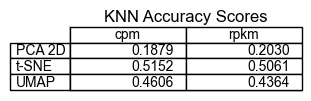

In [211]:
str_rna_types = np.array([str(r) for r in rna_type])


# TODO is this what they meant?
def get_knn_score(input, gt_labels=str_rna_types):
    max_accuracy = 0
    for neighbor in range(1, 30):
        knn = KNeighborsClassifier(n_neighbors=neighbor)
        X_train, X_test, y_train, y_test = train_test_split(
            input, gt_labels, random_state=42
        )
        knn.fit(X_train, y_train)
        prediction = knn.predict(X_test)
        accuracy = accuracy_score(y_test, prediction)
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_neighbor = neighbor
    return best_neighbor, max_accuracy

    # Note that the recall of the knn classifier is the same as the accuracy, for any of the averaging mode, as recall is a binary metric
    return [
        accuracy_score(y_test, prediction),
        recall_score(y_test, prediction, average="micro"),
    ]


def get_all_knn_scores(result_dict, title, f=lambda x: x):
    out_dict = dict()
    for norm_key, sub_dict in result_dict.items():
        out_dict[norm_key] = dict()
        for trans_key, pca_result in sub_dict.items():
            _, out_dict[norm_key][trans_key] = get_knn_score(f(pca_result))

    return out_dict


print(
    "Note that the recall of the knn classifier is the same as the accuracy, as recall is a binary metric\n"
)
high_dim_knn_score = get_all_knn_scores(pca_results, "PCA")
pca_knn_score = get_all_knn_scores(pca_results, "PCA 2D", lambda x: x[:, :2])
tsne_knn_score = get_all_knn_scores(tsne_results, "TSNE")
umap_knn_score = get_all_knn_scores(umap_results, "UMAP")

knn_scores = [pca_knn_score, tsne_knn_score, umap_knn_score]
plot_score_table(knn_scores, "KNN Accuracy Scores")

To achieve comparability in terms of the 2D respresentation, we calculate the accuracy score of the respective 2D representation divided by the knn accuracy 50-dimensional PCA respresentation over the thus normalizing it to the $[0, 1]$ interval

PCA 2D knn normalized accuracy: {'cpm': {'log': 0.33879781420765026}, 'rpkm': {'log': 0.3806818181818182}}
TSNE knn normalized accuracy: {'cpm': {'log': 0.9289617486338797}, 'rpkm': {'log': 0.9488636363636365}}
UMAP knn normalized accuracy: {'cpm': {'log': 0.8306010928961749}, 'rpkm': {'log': 0.8181818181818181}}


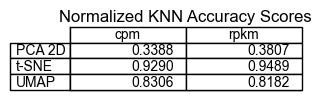

In [212]:
def normalize_knn_scores(scores):
    out_dict = dict()
    for norm_key, sub_dict in scores.items():
        out_dict[norm_key] = dict()
        for trans_key, score in sub_dict.items():
            out_dict[norm_key][trans_key] = (
                score / high_dim_knn_score[norm_key][trans_key]
            )

    return out_dict


print(f"PCA 2D knn normalized accuracy: {normalize_knn_scores(pca_knn_score)}")
print(f"TSNE knn normalized accuracy: {normalize_knn_scores(tsne_knn_score)}")
print(f"UMAP knn normalized accuracy: {normalize_knn_scores(umap_knn_score)}")

normalized_knn_scores = [
    normalize_knn_scores(pca_knn_score),
    normalize_knn_scores(tsne_knn_score),
    normalize_knn_scores(umap_knn_score),
]
plot_score_table(normalized_knn_scores, "Normalized KNN Accuracy Scores")

Again, we note that TSNE shows slightly better scores than UMAP.

Now that we have two scores that are both in the interval $[0, 1]$ we can combine them, i.e. taking the mean, to create an even more informed score

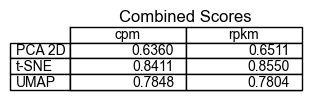

In [213]:
def get_combined_score(high_dim_matrix, low_dim_matrix):
    _, high_dim_accuracy = get_knn_score(high_dim_matrix)
    _, accuracy = get_knn_score(low_dim_matrix)
    dc = distance_correlation(high_dim_matrix, low_dim_matrix)
    return np.mean([accuracy / high_dim_accuracy, dc])


def get_all_combined_scores(result_dict, f=lambda x: x):
    out_dict = dict()
    for norm_key, sub_dict in result_dict.items():
        out_dict[norm_key] = dict()
        for trans_key, result in sub_dict.items():
            out_dict[norm_key][trans_key] = get_combined_score(
                pca_results[norm_key][trans_key], f(result)
            )

    return out_dict


combined_scores = [
    get_all_combined_scores(pca_results, lambda x: x[:, :2]),
    get_all_combined_scores(tsne_results),
    get_all_combined_scores(umap_results),
]
plot_score_table(combined_scores, "Combined Scores")

Consequently, TSNE also provides a better combined score for both normalizations (log-transformed). Within TSNE the CPM normalization has the highest score.

### Gridsearch over TSNE and UMAP hyperparameters

As mentioned earlier, the TSNE algorithm involves two hyperparameters that the user needs to provide, and these values can be optimized. In the following we intend to employ a grid search scheme over discrete set of values to determine the best ones. The set was selected through visual assessment after a few attempts.

In [214]:
# WARNING this cell takes a significant amount of time to run
# you can skip the execution and load the results from the .pkl file
# by setting RUN_GRIDSEARCH to False

RUN_GRIDSEARCH = False

# maximum perplexity imposed by TSNE (num_cells / 3 - 1)
# (giving a perplexity higher than this will result in using this number regardless)
num_cells = list(list(pca_results.values())[0].values())[0].shape[0]
max_perplexity = num_cells // 3 - 1

# for the following, we choose a more realistic maximum perplexity to reduce runtime
max_perplexity = 50
max_exaggeration = 2.5
# search spaces
perplexity_space = np.linspace(1, max_perplexity, 10, dtype=int)
exaggeration_space = np.linspace(0, max_exaggeration, 5, dtype=int)

if RUN_GRIDSEARCH:
    tsne_results = dict()
    tsne_hyperparams = dict()
    progress_bar = tqdm(
        total=perplexity_space.shape[0]
        * exaggeration_space.shape[0]
        * len(pca_results.items())
        * len(list(pca_results.values())[0].items())
    )
    for norm_key, sub_dict in pca_results.items():
        tsne_results[norm_key] = dict()
        tsne_hyperparams[norm_key] = dict()
        for trans_key, pca_result in sub_dict.items():
            (
                tsne_results[norm_key][trans_key],
                _,
                tsne_hyperparams[norm_key]["perplexity"],
                tsne_hyperparams[norm_key]["exaggeration"],
            ) = tsne_gridsearch(
                pca_result,
                perplexity_space,
                exaggeration_space,
                get_combined_score,
                progress_bar,
            )
            time.sleep(1)
    progress_bar.close()

    # save results
    pickle_out = open(intermediate_path / "tsne_results.pkl", "wb")
    pickle.dump((tsne_results, tsne_hyperparams), pickle_out)
    pickle_out.close()
else:
    # load results
    try:
        pickle_in = open(intermediate_path / "tsne_results.pkl", "rb")
        tsne_results, tsne_hyperparams = pickle.load(pickle_in)
        pickle_in.close()
    except FileNotFoundError:
        raise FileNotFoundError(
            "The results file does not exist. Please set 'RUN_GRIDSEARCH' to true and run this cell to create it."
        )

In [215]:
# WARNING this cell takes a significant amount of time to run
# you can skip the execution and load the results from the .pkl file
# by setting RUN_GRIDSEARCH to False

RUN_GRIDSEARCH = False

# for the following, we choose a more realistic maximum perplexity to reduce runtime
max_neighbors = 50

# umap requires a minimum number of neighbors where the resulting graph is fully connected
min_neighbors = 3

# search spaces
neighbor_space = np.arange(min_neighbors, max_neighbors + 1)

if RUN_GRIDSEARCH:
    umap_results = dict()
    umap_hyperparams = dict()
    progress_bar = tqdm(
        total=neighbor_space.shape[0]
        * len(pca_results.items())
        * len(list(pca_results.values())[0].items())
    )
    for norm_key, sub_dict in pca_results.items():
        umap_results[norm_key] = dict()
        umap_hyperparams[norm_key] = dict()
        for trans_key, pca_result in sub_dict.items():
            (
                umap_results[norm_key][trans_key],
                _,
                umap_hyperparams[norm_key]["neighbors"],
            ) = umap_gridsearch(
                pca_result,
                neighbor_space,
                get_combined_score,
                progress_bar,
            )
            time.sleep(1)
    progress_bar.close()

    # save results
    pickle_out = open(intermediate_path / "umap_results.pkl", "wb")
    pickle.dump((umap_results, umap_hyperparams), pickle_out)
    pickle_out.close()
else:
    # load results
    try:
        pickle_in = open(intermediate_path / "umap_results.pkl", "rb")
        umap_results, umap_hyperparams = pickle.load(pickle_in)
        pickle_in.close()
    except FileNotFoundError:
        raise FileNotFoundError(
            "The results file does not exist. Please set 'RUN_GRIDSEARCH' to true and run this cell to create it."
        )

Now we can make a final comparison, of the the two remaining normalization techniques and the three 2D representations

In [216]:
tsne_hyperparams, umap_hyperparams

({'cpm': {'perplexity': 33, 'exaggeration': 1},
  'rpkm': {'perplexity': 6, 'exaggeration': 2}},
 {'cpm': {'neighbors': 4}, 'rpkm': {'neighbors': 4}})

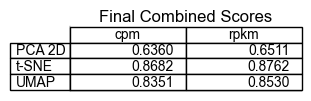

In [217]:
combined_scores = [
    get_all_combined_scores(pca_results, lambda x: x[:, :2]),
    get_all_combined_scores(tsne_results),
    get_all_combined_scores(umap_results),
]

plot_score_table(combined_scores, "Final Combined Scores")

Here we can see that the optimized TSNE on the CPM normalization performs best on our metric.  
Therefore, in later analysis we will continue to use this 2D representation, removing every other one.

In [218]:
try:
    del count_dict["rpkm"]
    del tsne_results["rpkm"]
    del pca_results["rpkm"]
    del tsne_hyperparams["rpkm"]
except KeyError:
    pass

Optimized TSNE hyperparameters: {'perplexity': 33, 'exaggeration': 1}


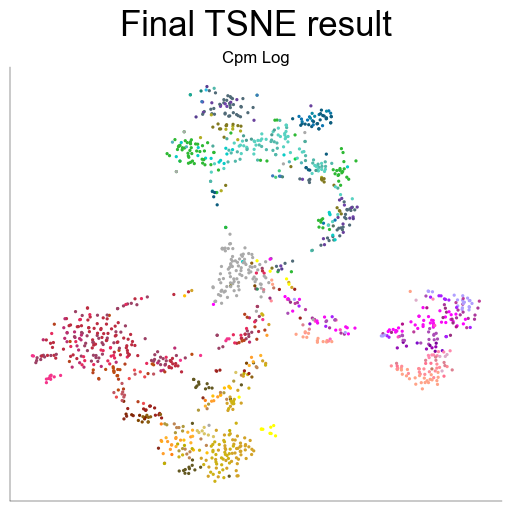

In [219]:
print(f"Optimized TSNE hyperparameters: {list(tsne_hyperparams.values())[0]}")
plot_2d_vis(tsne_results, "Final TSNE result", cluster_colors, transpose=True)

This is the final TSNE result. Note that still we do not achieve perfect cluster structures. However, this could be an issue with the data not with the algorithm. 

# Clustering

The aim of cluster algorithms is to group similar data points together based on certain criteria or patterns in the data. These algorithms attempt to identify natural clusters or subgroups within a dataset, where data points within the same cluster are more similar to each other than to those in other clusters. In this section, our goal is to evaluate four cluster algorithms on our dataset to determine if any of them can accurately match the provided underlying ground truth.




## K-Means

K-means is used to partition data into K distinct clusters. It works by iteratively assigning data points to the nearest cluster centroid and then updating the centroids based on the mean of the assigned data points. The algorithm aims to minimize the total sum of squared distances between data points and their respective cluster centroids.

To make K-Means work we have to choose an appropriate K. Because hyperparameter optimiziation using the native KMEANS().score() function did not result in any reasonable number, we decided to manually test a few Ks and ended up on 10.

In [220]:
_, counts = np.unique(cluster_colors, return_counts=True)

n_clusters = np.sum(counts > 0)
n_clusters = 10
print(f"Number of clusters: {n_clusters}")
k_means_labels = dict()
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
for norm_key, sub_dict in pca_results.items():
    k_means_labels[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        k_means_labels[norm_key][trans_key] = kmeans.fit_predict(pca_result)

Number of clusters: 10


/Users/leander/Documents/UNI/Master/Neural Data Science - SoSe23/Coding Labs/final_project/utils.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[row, col].scatter(


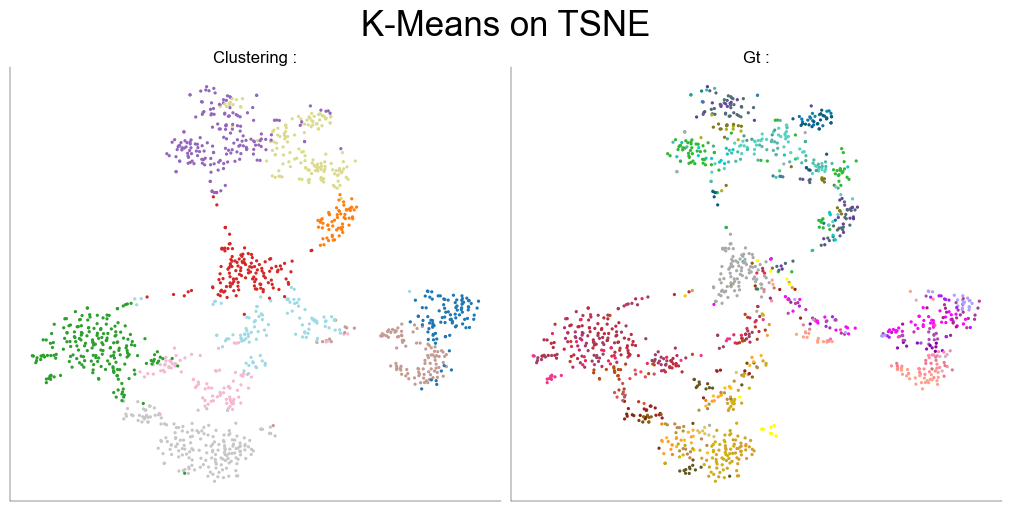

In [221]:
new_tsne = dict()
new_tsne["clustering"] = dict()
new_tsne["clustering"][":"] = tsne_results["cpm"]["log"]
new_tsne["GT"] = dict()
new_tsne["GT"][":"] = tsne_results["cpm"]["log"]

cluster = dict()
cluster["clustering"] = dict()
cluster["clustering"][":"] = k_means_labels["cpm"]["log"]
cluster["GT"] = dict()
cluster["GT"][":"] = cluster_colors

plot_2d_vis(new_tsne, "K-Means on TSNE", cluster, transpose=True)

While the clustering look good on TSNE, it does not really resemble the original clustering, as can be expected from a simple algorithm without proper hyperparameter tuning.

## Leiden Clustering

We have already discussed Leiden Clustering on an exercise sheet. 

In [222]:
leiden_partition = dict()
leiden_labels = dict()
for norm_key, sub_dict in pca_results.items():
    leiden_partition[norm_key] = dict()
    leiden_labels[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        A = kneighbors_graph(pca_result, 15)
        sources, targets = A.nonzero()
        g = ig.Graph(directed=False)
        g.add_vertices(A.shape[0])
        g.add_edges(list(zip(sources, targets)))
        leiden_partition[norm_key][trans_key] = la.find_partition(
            g, la.RBConfigurationVertexPartition
        )
        leiden_labels[norm_key][trans_key] = leiden_partition[norm_key][
            trans_key
        ].membership

/Users/leander/Documents/UNI/Master/Neural Data Science - SoSe23/Coding Labs/final_project/utils.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[row, col].scatter(


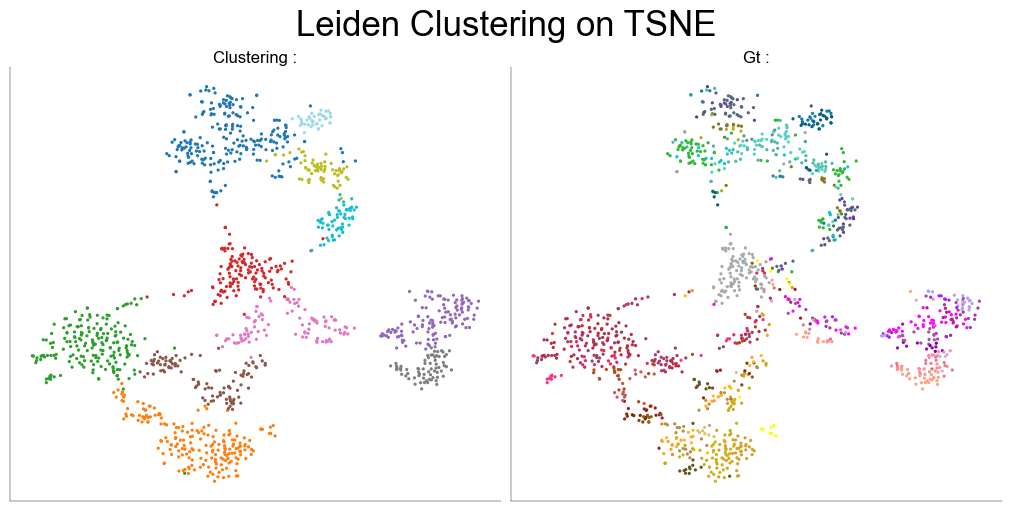

In [223]:
cluster["clustering"][":"] = leiden_labels["cpm"]["log"]
plot_2d_vis(new_tsne, "Leiden Clustering on TSNE", cluster, transpose=True)

## Gaussian Mixture Models
 
Gaussian Mixture Models (GMMs) assume that the data is generated from a mixture of multiple Gaussian distributions. Note that this is in particular **not** the case for our data. GMMs aim to identify the underlying components and their associated probabilities to model the data accurately. Each Gaussian component represents a cluster, and the model helps in assigning data points to their respective clusters based on the probability distribution.

In [224]:
max_n_clusters = 110
print(f"Maximum number of clusters: {max_n_clusters}")
gmm_labels = dict()
for norm_key, sub_dict in pca_results.items():
    gmm_labels[norm_key] = dict()
    for trans_key, pca_result in sub_dict.items():
        _, gmm_labels[norm_key][trans_key] = choose_n_clusters(
            pca_result, GaussianMixture, max_n_clusters
        )

Maximum number of clusters: 110


100%|██████████| 110/110 [00:49<00:00,  2.21it/s]

Best result: 44 clusters, BIC = 398113.52348378714


/Users/leander/Documents/UNI/Master/Neural Data Science - SoSe23/Coding Labs/final_project/utils.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[row, col].scatter(


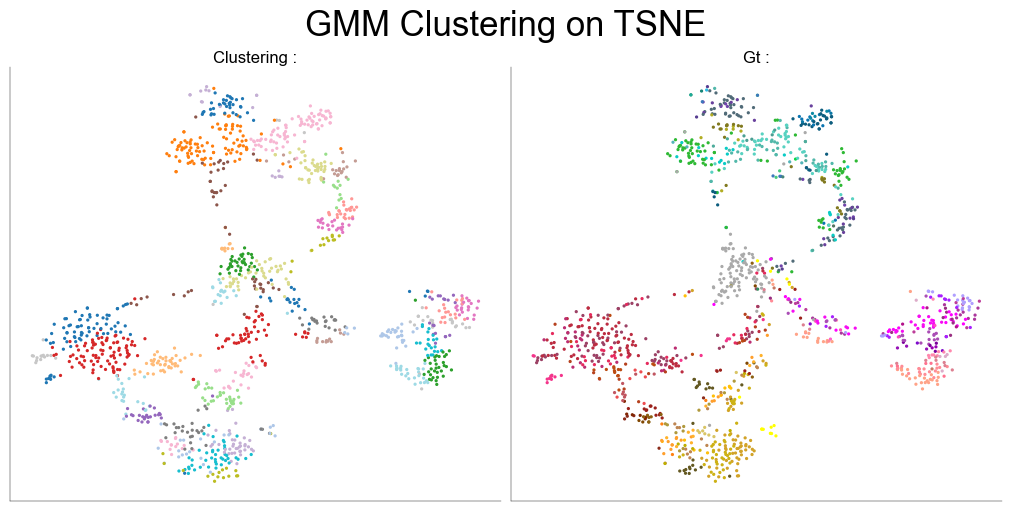

In [225]:
cluster["clustering"][":"] = gmm_labels["cpm"]["log"]
plot_2d_vis(new_tsne, "GMM Clustering on TSNE", cluster, transpose=True)

## Negative Binomial Mixture Model

Unlike Gaussian Mixture Models (GMMs), Negative Binomial Mixture Models (NBMMs) are designed for count data instead of assuming Gaussian distributions. This characteristic makes NBMMs particularly appealing for our specific case.

While Harris et al. (2018) calculated the number of clusters inherently in their algorithm, we opted for a different approach. Similar to our GMMs approach, we conducted a grid search to determine the optimal number of clusters.

Apart from this difference, we follow the approach of Harris et al. (2018), where we fix the dispersion parameter $r=2$ and utilize hard Expectation-Maximization to optimize the model parameters. Since we already reduced ourselves to 500 genes in feature selection, we refrain from specifying a subgroup of interesting genes like the paper.

In [226]:
max_n_clusters = 110
print(f"Maximum number of clusters: {max_n_clusters}")
nbmm_labels = dict()
for norm_key, sub_dict in count_dict.items():
    nbmm_labels[norm_key] = dict()
    for trans_key, result in sub_dict.items():
        _, nbmm_labels[norm_key][trans_key] = choose_n_clusters(
            result, NBMM, max_n_clusters
        )

Maximum number of clusters: 110


100%|██████████| 110/110 [02:04<00:00,  1.13s/it]

Best result: 110 clusters, BIC = 2534719.5978194796


/Users/leander/Documents/UNI/Master/Neural Data Science - SoSe23/Coding Labs/final_project/utils.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[row, col].scatter(


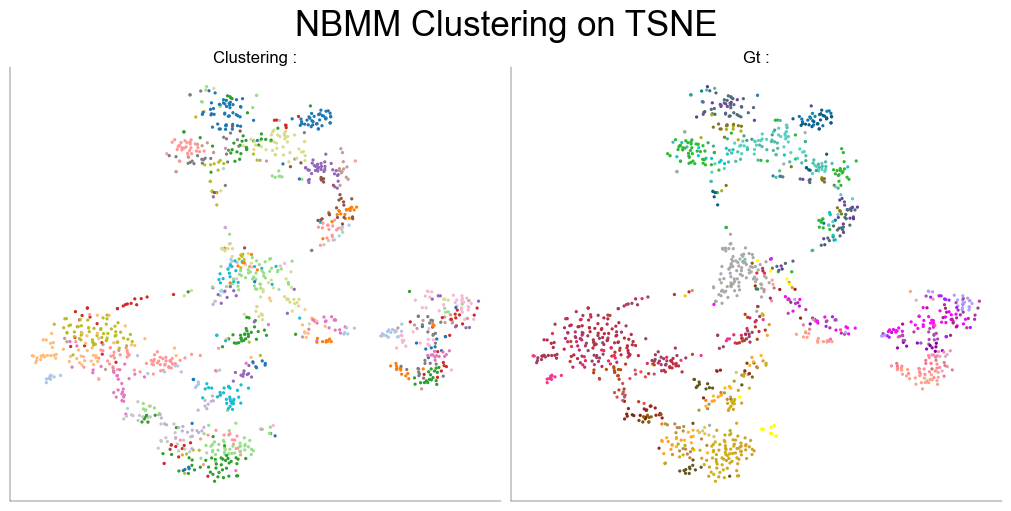

In [227]:
cluster["clustering"][":"] = nbmm_labels["cpm"]["log"]
plot_2d_vis(new_tsne, "NBMM Clustering on TSNE", cluster, transpose=True)

## Discussion via different metrics

We evaluate the clustering on three different metrics: 

1. Adjusted Rand Index: computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
2. Adjusted Mutual Information score: evaluates the mutual information between the expected clustering and the ground truth clustering, corrected for the chance.
3. Difference of number of cluster: Gives the absolute difference between the ground truth number of cluster and the predicted number of clusters by the algorithms.

In [228]:
print(
    f'Rand score of K-Means Clustering: {adjusted_rand_score(cluster_colors, k_means_labels["cpm"]["log"])}'
)
print(
    f'Rand score of Leiden Clustering: {adjusted_rand_score(cluster_colors, leiden_labels["cpm"]["log"])}'
)
print(
    f'Rand score of GMM Clustering: {adjusted_rand_score(cluster_colors, gmm_labels["cpm"]["log"])}'
)
print(
    f'Rand score of NBMM Clustering: {adjusted_rand_score(cluster_colors, nbmm_labels["cpm"]["log"])}'
)

Rand score of K-Means Clustering: 0.206472084909337
Rand score of Leiden Clustering: 0.219594463198642
Rand score of GMM Clustering: 0.2328915041940731
Rand score of NBMM Clustering: 0.20420341127222516


In [229]:
print(
    f'AMI score of K-Means Clustering: {adjusted_mutual_info_score(cluster_colors, k_means_labels["cpm"]["log"])}'
)
print(
    f'AMI score of Leiden Clustering: {adjusted_mutual_info_score(cluster_colors, leiden_labels["cpm"]["log"])}'
)
print(
    f'AMI score of GMM Clustering: {adjusted_mutual_info_score(cluster_colors, gmm_labels["cpm"]["log"])}'
)
print(
    f'AMI score of NBMM Clustering: {adjusted_mutual_info_score(cluster_colors, nbmm_labels["cpm"]["log"])}'
)

AMI score of K-Means Clustering: 0.4137736036583121
AMI score of Leiden Clustering: 0.45270407651834454
AMI score of GMM Clustering: 0.4604192742614508
AMI score of NBMM Clustering: 0.43361966235474053


In [230]:
def num_cluster_comparison(gt_labels, pred_labels):
    n_gt_label = len(np.unique(gt_labels))
    n_pred_label = len(np.unique(pred_labels))

    return np.abs(n_gt_label - n_pred_label), n_pred_label


kmeans_cluster_score, kmeans_n_clusters = num_cluster_comparison(
    cluster_colors, k_means_labels["cpm"]["log"]
)
print(
    f"Difference of number of clusters score of K-Means Clustering: {kmeans_cluster_score},\t number of clusters: {kmeans_n_clusters}"
)
leiden_cluster_score, leiden_n_clusters = num_cluster_comparison(
    cluster_colors, leiden_labels["cpm"]["log"]
)
print(
    f"Difference of number of clusters score of Leiden Clustering: {leiden_cluster_score},\t number of clusters: {leiden_n_clusters}"
)
gmm_cluster_score, gmm_n_clusters = num_cluster_comparison(
    cluster_colors, gmm_labels["cpm"]["log"]
)
print(
    f"Difference of number of clusters score of GMM Clustering: {gmm_cluster_score},\t\t number of clusters: {gmm_n_clusters}"
)
nbmm_cluster_score, nbmm_n_clusters = num_cluster_comparison(
    cluster_colors, nbmm_labels["cpm"]["log"]
)
print(
    f"Difference of number of clusters score of NBMM Clustering: {nbmm_cluster_score},\t\t number of clusters: {nbmm_n_clusters}"
)

Difference of number of clusters score of K-Means Clustering: 67,	 number of clusters: 10
Difference of number of clusters score of Leiden Clustering: 66,	 number of clusters: 11
Difference of number of clusters score of GMM Clustering: 33,		 number of clusters: 44
Difference of number of clusters score of NBMM Clustering: 33,		 number of clusters: 110


**Analysis**: For both scores Leiden clustering is the best although no hyperparameter optimization was performed. We disregard the high difference in outputted cluster, because we saw in "Compute Statistics" that there are many cluster that only one or a few cells. 
That is why as a next step we optimize the resolution parameter via grid search with respect to the mean of the scores. 



In [231]:
def score_clustering(true_labels, pred_labels):
    """
    Computes the accuracy score of a clustering.
    """
    return np.mean(
        [
            adjusted_rand_score(true_labels, pred_labels),
            adjusted_mutual_info_score(true_labels, pred_labels),
        ]
    )


def leiden_grid_search(gt_labels, input_data):
    """
    Perform a grid search over the resolution parameter for the Leiden algorithm.
    """
    resolutions = np.linspace(0.1, 4, 100)
    best_partition = None
    best_score = -np.inf
    best_resolution = None
    A = kneighbors_graph(input_data, 15)
    sources, targets = A.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(A.shape[0])
    g.add_edges(list(zip(sources, targets)))
    for resolution in tqdm(resolutions):
        pred_labels = la.find_partition(
            g,
            la.RBConfigurationVertexPartition,
            resolution_parameter=resolution,
        ).membership
        score = score_clustering(gt_labels, pred_labels)
        if score > best_score:
            best_partition = pred_labels
            best_resolution = resolution
            best_score = score
    return best_partition, best_resolution


best_leiden_labels, resolution_param = leiden_grid_search(
    cluster_colors, pca_results["cpm"]["log"]
)

100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


In [232]:
leiden_cluster_score, leiden_n_clusters = num_cluster_comparison(
    cluster_colors, best_leiden_labels
)
print(
    f"Rand score of Leiden Clustering: {adjusted_rand_score(cluster_colors, best_leiden_labels)}"
)
print(
    f"AMI score of Leiden Clustering: {adjusted_mutual_info_score(cluster_colors, best_leiden_labels)}"
)
print(
    f"Difference of number of clusters score of Leiden Clustering: {leiden_cluster_score},\t number of clusters: {leiden_n_clusters}"
)
cluster["clustering"][":"] = best_leiden_labels

Rand score of Leiden Clustering: 0.30016839380685767
AMI score of Leiden Clustering: 0.5116145833330785
Difference of number of clusters score of Leiden Clustering: 48,	 number of clusters: 29


/Users/leander/Documents/UNI/Master/Neural Data Science - SoSe23/Coding Labs/final_project/utils.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[row, col].scatter(


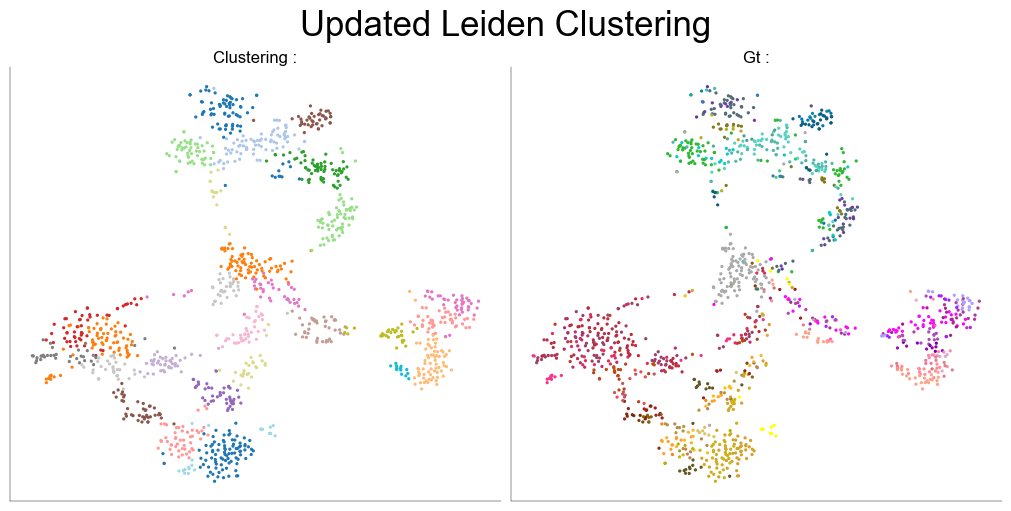

In [233]:
plot_2d_vis(new_tsne, "Updated Leiden Clustering", cluster, transpose=True)

This is our end result for this section. We see that the optimized leiden clustering captures the structure of the ground truth labelling reasonably well, despite having found significantly less clusters, reflecting the highest score within the tested clustering algorithms.

This can be at least partially explained by the high number of clusters in the ground truth labels with very small sizes (i.e. containing only 1 or 2 cells) - see bar plot in the "Compute Statistics" section.

# Correlation in between Electrophysiological Features and Genes/PCs

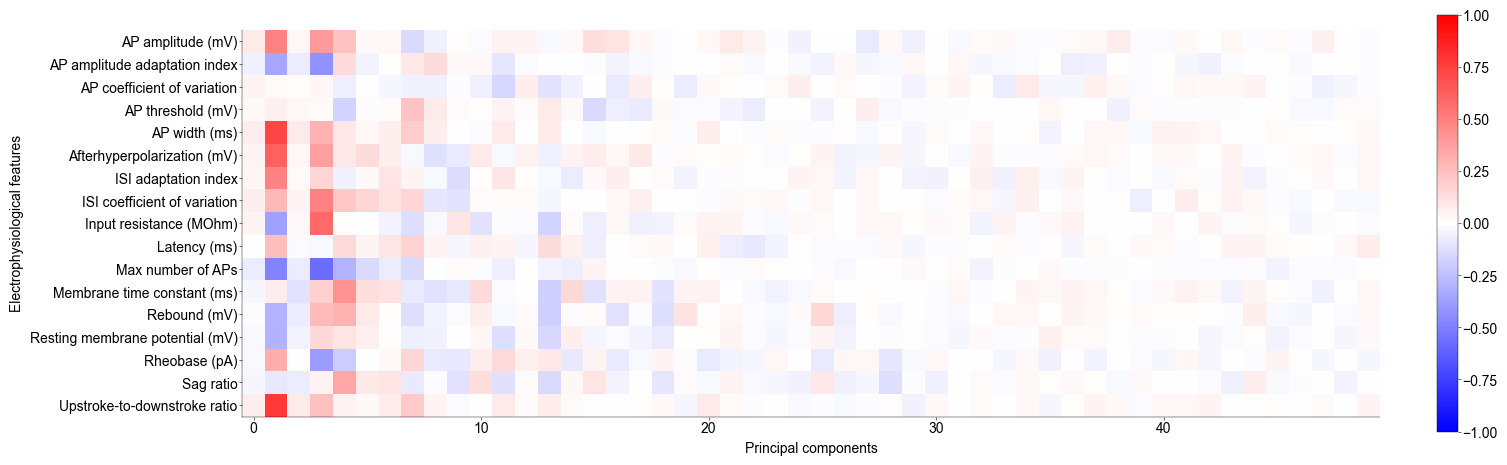

In [234]:
# calculate correlation matrix between PCs and electrophysiological features
data = np.concatenate((ephysData_filtered, pca_results["cpm"]["log"]), axis=1)
corr = np.corrcoef(data, rowvar=False)
corr = corr[ephysData_filtered.shape[1] :, : ephysData_filtered.shape[1]]


# Plot correlation matrix
fig, ax = plt.subplots(figsize=(15, 4.6))
im = ax.imshow(corr.T, cmap="bwr", vmin=-1, vmax=1)
ax.set_xlabel("Principal components")
ax.set_ylabel("Electrophysiological features")
ax.set_yticks(range(len(ephysNames_filtered)))
ax.set_yticklabels(ephysNames_filtered)
ax.figure.colorbar(im, ax=ax)

plt.show()

**Analysis:** 

The data clearly reveals strong correlations between most electrophysiological features and the second and fourth principal components, especially with respect to the second component. On the other hand, the first and third principal components demonstrate minimal correlation with the electrophysiological features. As we move beyond the first four components, there are no significant or remarkable correlations. Notably, a discernible trend emerges: correlations tend to decrease with higher principal components.  
Another interesting observation is, that some electrophysiolagical features do show strong correlation with any principal component, meaning they are likely not caused by or related to any of the genes examined here (which are only the 500 most variable genes out of the over 42.000 from the original dataset).

To dive a little bit deeper into this analysis we take a closer look at the second PC, which is strongly correlated to many of the electrophysiological features.

In [235]:
# 2nd principal component of the log-transformed CPM data
pc = pca_components["cpm"]["log"][1, :]

n_genes = 20
# the 10 genes with the highest absolute value of pc2
genes_of_interest_i = np.abs(pc).argsort()[::-1][:n_genes]
genes_of_interest = genes_filtered[genes_of_interest_i]

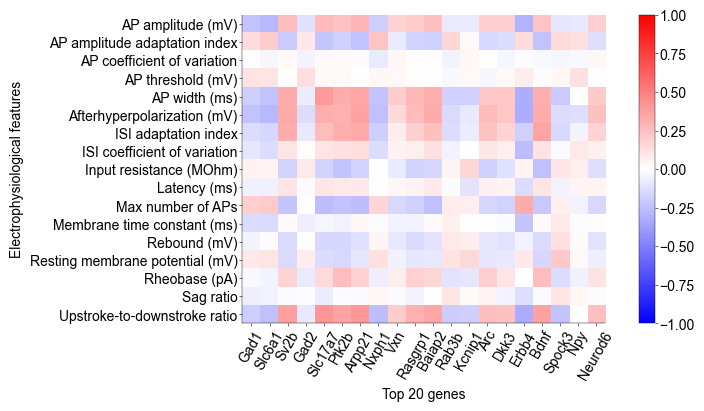

In [236]:
# calculate correlation matrix between these 10 genes and electrophysiological features
data = np.concatenate(
    (ephysData_filtered, exonCounts_filtered[:, genes_of_interest_i]), axis=1
)
corr_genes = np.corrcoef(data, rowvar=False)
corr_genes = corr_genes[
    ephysData_filtered.shape[1] :, : ephysData_filtered.shape[1]
]


# Plot correlation matrix
fig, ax = plt.subplots(figsize=(7, 4))
im = ax.imshow(corr_genes.T, cmap="bwr", vmin=-1, vmax=1)
ax.set_xlabel(f"Top {n_genes} genes")
ax.set_ylabel("Electrophysiological features")
ax.set_yticks(range(len(ephysNames_filtered)))
ax.set_yticklabels(ephysNames_filtered)
ax.set_xticks(range(len(genes_of_interest)))
ax.set_xticklabels(genes_of_interest, rotation=60)
ax.figure.colorbar(im, ax=ax)

plt.show()

Within the 2nd principal component, we sort the genes, by how strongly they are represented. Then we plot the correlations of the 20 genes, that are most prominent in the 2nd principal component, with the electrophysiological features. This results in a display of strong (positive and negative) correlations between the selected genes and features.


In the following, we go back to the TSNE representation of the genes and color the datapoints according to two elecrophysiological features that seemed to have the strongest correlations with many of the genes in the plots above.

In [237]:
n_ef = 2
idx = np.abs(corr[1, :]).argsort()[::-1][:n_ef]
feature_names = ephysNames_filtered[idx]

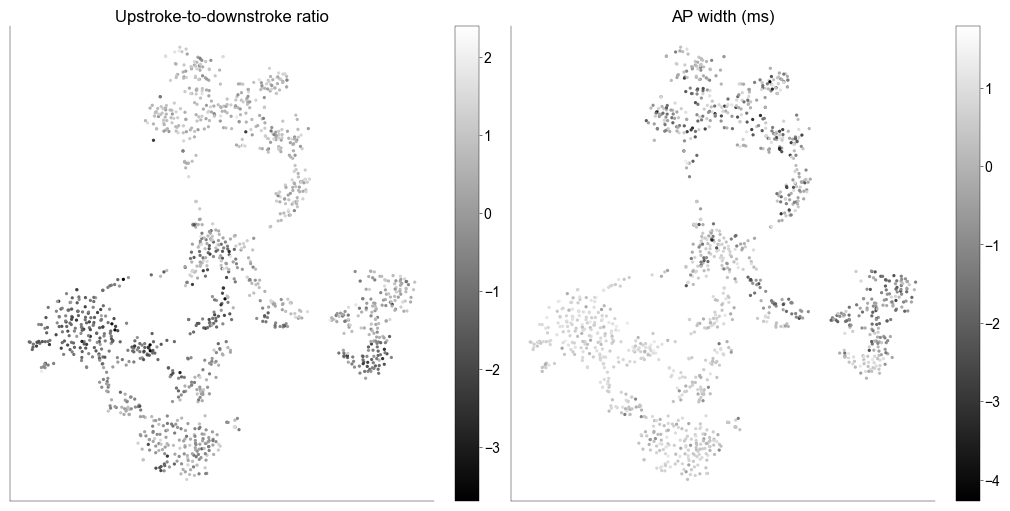

In [238]:
i = np.argmax(ephysNames_filtered == feature_name)
fig, ax = plt.subplots(1, n_ef, figsize=(5 * n_ef, 5))
for i in range(n_ef):
    sc = ax[i].scatter(
        tsne_results["cpm"]["log"][:, 0],
        tsne_results["cpm"]["log"][:, 1],
        s=7,
        c=ephysData_filtered[:, i],
        cmap="gray",
    )
    fig.colorbar(sc, ax=ax[i])
    ax[i].set_title(feature_names[i])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

We can clearly see that some electrophysiological are heavily correlated with the genes contained in the cell and thus, by extension with the cell type. Therefore our TSNE representation, which aims to depict the RNA type structure also shows this correlation.

# Discussion

In this project, we examined transcriptomic data, and our analysis involved focusing on 500 genes by utilizing the mean-dropout relationship and computing necessary statistics. Subsequently, we employed TSNE and UMAP to display the data in a two-dimensional space. To identify meaningful clusters, we experimented with various clustering algorithms and compared their results. Finally, we extracted genes that showed a high correlation with specific electrophysiological features and visualized this relationship for the most significant ones.

While TSNE seems to be the best method for two-dimensional visualization by our metrics, it fails to capture the exact structure of the ground truth RNA type labels. However, this may very well be caused by the dataset rather than the method itself. The same principal applies to the clustering algorithms, where Leiden clustering performs the best. Yet, it only manages to produce 16 clusters, which is significantly lower than the 77 clusters present in the original dataset. Despite these imperfections, we identify strong correlations between the electrophysiological features and the principal components. We trace these correlations back to the corresponding genes and derive a subset of the genes that shows the heaviest correlations. Additionally, we take a closer look at the two electrophysiological features that exhibit the largest correlations with pricipal components and plot them on our two-dimensional visualisations of cells.

Further analysis would include to leverage the scalability of UMAP to obtain a two-dimensional visualization from higher-dimensional data, surpassing the limitation of using only the first 50 principal components. Additionally, we could improve the hyperparameter optimization for K-Means and Leiden clustering by introducing a meaningful metric capturing relevant properties like the BIC score. Variations of GMMs and NBMMs can find the number of clusters inherently, i.e. no hyperparameter optimization is needed. Implementation of such variations could yield different, improved results and might be worth it. 





# References

- Renesh Bedre. (2020, March 5). reneshbedre/bioinfokit: Bioinformatics data analysis and visualization toolkit. Zenodo. http://doi.org/10.5281/zenodo.3698145.
- Kobak, D., Berens, P. The art of using t-SNE for single-cell transcriptomics. Nat Commun 10, 5416 (2019). https://doi.org/10.1038/s41467-019-13056-x
- Tallulah S Andrews , Martin Hemberg, M3Drop: dropout-based feature selection for scRNASeq, Bioinformatics, Volume 35, Issue 16, August 2019, Pages 2865–2867, https://doi.org/10.1093/bioinformatics/bty1044
- Harris KD, Hochgerner H, Skene NG, Magno L, Katona L, Bengtsson Gonzales C, et al. (2018) Classes and continua of hippocampal CA1 inhibitory neurons revealed by single-cell transcriptomics. PLoS Biol 16(6): e2006387. https://doi.org/10.1371/journal.pbio.2006387
- Scala, F., Kobak, D., Bernabucci, M. et al. Phenotypic variation of transcriptomic cell types in mouse motor cortex. Nature 598, 144–150 (2021). https://doi.org/10.1038/s41586-020-2907-3
- Van der Maaten, L. and Hinton, G., 2008. Visualizing data using t-SNE. Journal of machine learning research, 9(11).
- McInnes, Leland and John Healy. “UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction.” ArXiv abs/1802.03426 (2018): n. pag.
- Hubert, L., Arabie, P. Comparing partitions. Journal of Classification 2, 193–218 (1985). https://doi.org/10.1007/BF01908075